In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpt
from scipy.fftpack import fft,ifft
import seaborn
import csv

In [6]:
force_01 = pd.read_csv(r'D:\data\20190513\Force\20190513_01_new.csv')
force_all = force_01

(211530,)


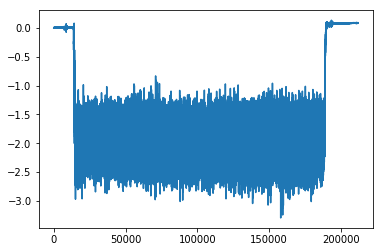

In [7]:
force_all_0 = force_all.query('Fx12!=0 and Fx34!=0 and Fy14!=0')
print(force_all_0.My.shape)
#plt.figure(figsize=(16, 8))
plt.plot(force_all_0.My)

(174820,)


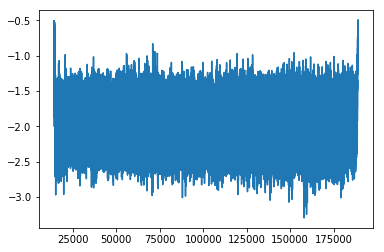

In [8]:
force_all_1 = force_all_0.query('My<-0.5 and My>-4.25')
print(force_all_1.Fx12.shape)
plt.plot(force_all_1.My)

(300,)


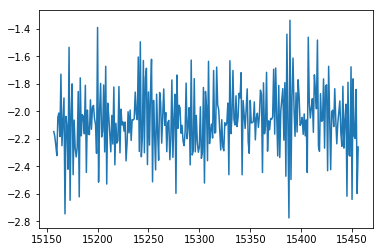

In [9]:
y_front = force_all_1.My[1000:1300]
print(y_front.shape)
plt.plot(y_front)

(1000,)


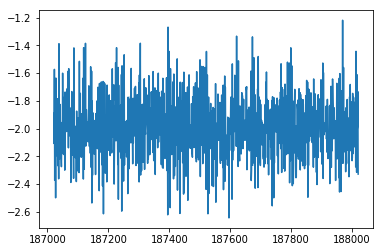

In [10]:
y_back = force_all_1.My[-2000:-1000]
print(y_back.shape)
plt.plot(y_back)

# 深度学习（图片代码改cuda）

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 数据库模块
from torch.autograd import Variable
import time

In [15]:
data_csv = force_all_1.My
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [12]:
time_start=time.time()
torch.manual_seed(1)    # reproducible
 
# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 64  #批量大小
TIME_STEP = 28      # rnn 时间步数 / 图片高度
INPUT_SIZE = 28     # rnn 每步输入值 / 图片每行像素
LR = 0.01           # learning rate

In [13]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [16]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [17]:
# 划分训练集和测试集，70% 作为训练集
#train_size = int(len(data_X) * 0.7)
#test_size = len(data_X) - train_size
train_X = data_X[3000:3500]
train_Y = data_Y[3000:3500]
test_X = data_X[3500:3800]
test_Y = data_Y[3500:3800]

In [18]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [19]:
train_x = train_x.cuda()
train_y = train_y.cuda()
test_x = test_x.cuda()

In [20]:
train_x = train_x.cuda()
train_y = train_y.cuda()
test_x = test_x.cuda()

In [21]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
 
        self.rnn = nn.LSTM(     # LSTM 效果要比 nn.RNN() 好多了
            input_size=INPUT_SIZE,      # 图片每行的数据像素点
            hidden_size=64,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
        )
 
        self.out = nn.Linear(64, 10)    # 输出层
 
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)   LSTM 有两个 hidden states, h_n 是分线, h_c 是主线
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None 表示 hidden state 会用全0的 state,表示没有第一个h
 
        # 选取最后一个时间点的 r_out 输出
        # 这里 r_out[:, -1, :] 的值也是 h_n 的值
        out = self.out(r_out[:, -1, :])  #最后一个时刻的选取
        return out
 
rnn = RNN()
rnn.cuda()    #模型使用了cuda()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [22]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

In [23]:
# training and testing
for epoch in range(EPOCH):
    for step, (x, b_y) in enumerate(train_loader):   # gives batch data
        x = Variable(x).cuda()
        b_y = Variable(b_y).cuda()     #训练数据使用了cuda（）
        b_x = x.view(-1, 28, 28)   # reshape x to (batch, time_step, input_size)
 
        output = rnn(b_x)               # rnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].cpu().data.numpy().squeeze()   #得转换为cpu（）,不然出现：can't convert CUDA tensor to numpy (it doesn't support GPU arrays). Use .cpu() to move the tensor to host memory first.
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

time_end=time.time()
print('time cost',time_end-time_start,'s')

KeyError: 95